In [ ]:
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow
import cv2 as cv
import math
from scipy.signal import correlate2d
import matplotlib.pyplot as plt

In [ ]:
def preprocess_img(im_in):
  original_image = Image.open(im_in)
  resized_image = original_image.resize((256, 256))
  im = np.array(resized_image.convert('L'))
  im_uint8 = ((im - np.min(im)) * (1/(np.max(im) - np.min(im)) * 255)).astype(float)
  return im_uint8

In [ ]:
def convolution(f, I, dim, ph, pw, typ):
  if typ == 'Mask':
    if dim == 2:
      im_conv = np.zeros((I.shape[0]-2*ph, I.shape[1]-2*pw))
      for y in range(ph, I.shape[0]-ph):
        for x in range(pw, I.shape[1]-pw):
          im_conv[y-ph][x-pw] = np.sum(np.multiply(I[y-ph:y+ph+1, x-pw:x+pw+1], f))
    elif dim == 1:
      fX = np.zeros((I.shape[0], I.shape[1] - pw + 1))
      for i, v in enumerate(f):
        fX += v * I[:, i : I.shape[1] - pw + i + 1]
      fY = np.zeros((fX.shape[0] - ph + 1, fX.shape[1]))
      for i, v in enumerate(f):
        fY += v * fX[i : I.shape[0] - ph + i + 1]
      im_conv = fY
    return im_conv
  elif typ == 'Derivative':
    fX = np.zeros((I.shape[0], I.shape[1] - pw + 1))
    for i, v in enumerate(f):
      fX += v * I[:, i : I.shape[1] - pw + i + 1]
    fY = np.zeros((I.shape[0] - ph + 1, I.shape[1]))
    for i, v in enumerate(f):
      fY += v * I[i : I.shape[0] - ph + i + 1, :]
    return fX, fY

In [ ]:
def gaussianKernel(size, sigma, dim):
  padding = int((size-1)/2)
  if dim == 2:
      f = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
  elif dim == 1:
      f = np.fromfunction(lambda x: math.e ** ((-1*(x-(size-1)/2)**2) / (2*sigma**2)), (size,))
  return f / np.sum(f), padding

In [ ]:
def gaussianBlur(I, size, sigma, dim):
  if dim == 2:
    f, padding = gaussianKernel(size, sigma, dim)
    return convolution(f, I, dim, padding, padding, 'Mask')
  elif dim == 1:
    f, padding = gaussianKernel(size, sigma, dim)
    return convolution(f, I, dim, size, size, 'Mask')

In [ ]:
def createBorder(img,TDLU):
  borderType = cv.BORDER_CONSTANT
  img = cv.copyMakeBorder(img, TDLU[0] , TDLU[1] , TDLU[2] , TDLU[3] , borderType, None, 0)
  row, col = img.shape
  return img

In [ ]:
def derivativeFilter(I):
  d = [-1, 0, 1]
  dX, dY = convolution(d, I, 1, len(d), len(d), 'Derivative')
  h, w = dX.shape
  dX = createBorder(dX, [0, 0, 0, h-w])
  h, w = dY.shape
  dY = createBorder(dY, [0,w-h,0,0])
  return dX, dY

In [ ]:
def gradientMagnitude(I, dX, dY):
  for i in range(len(dX)):
    for j in range(len(dX[i])):
      I[i][j] = ((dX[i][j])**2 + (dY[i][j])**2)**0.5
  h, w = I.shape
  I = np.delete(I, [h-1, h-2], 0)
  I = np.delete(I, [w-1, w-2], 1)
  return I

In [ ]:
def edgeDetection(im_in):
  print('Edge Det - Input')
  cv2_imshow(im_in)
  g = gaussianBlur(im_in, 3, 2, 2)
  print('2D Gaussian Blur')
  cv2_imshow(g)
  g1 = gaussianBlur(im_in, 3, 2, 1)
  print('1D Gaussian Blur')
  cv2_imshow(g1)
  dX, dY = derivativeFilter(g1)
  print('X Derivative')
  cv2_imshow(dX)
  print('Y Derivative')
  cv2_imshow(dY)
  gm = gradientMagnitude(im_in, dX, dY)
  print('Gradient Magnitude')
  cv2_imshow(gm)
  gm = (gm).astype(np.uint8)
  ret, thresh1 = cv.threshold(gm, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
  print('Edge Detection Image')
  cv2_imshow(thresh1)
  return thresh1

Edge Det - Input


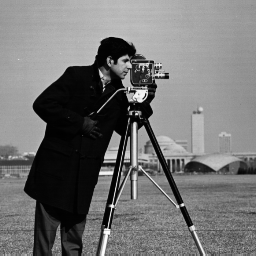

2D Gaussian Blur


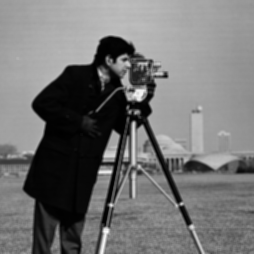

1D Gaussian Blur


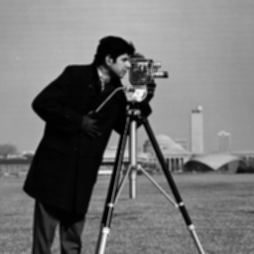

X Derivative


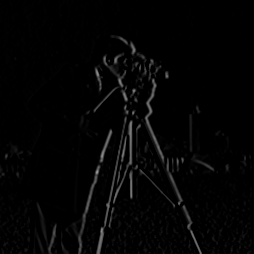

Y Derivative


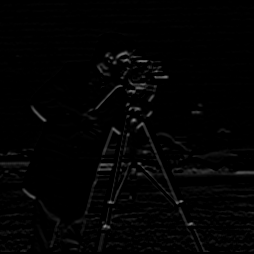

Gradient Magnitude


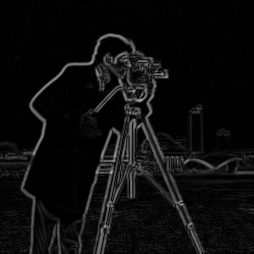

Edge Detection Image


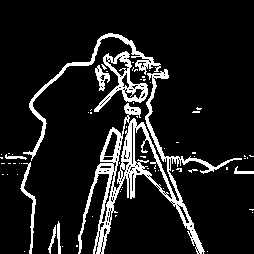

In [ ]:
im_in = preprocess_img('cameraman.png')
thresh1 = edgeDetection(im_in)

Edge Det - Input


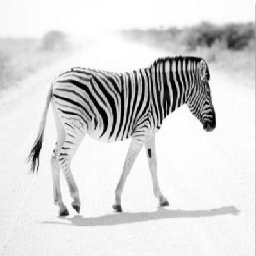

2D Gaussian Blur


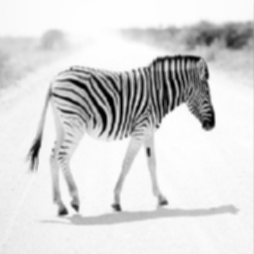

1D Gaussian Blur


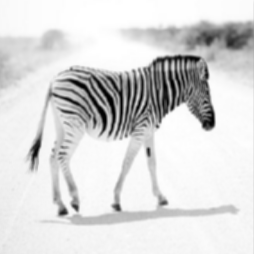

X Derivative


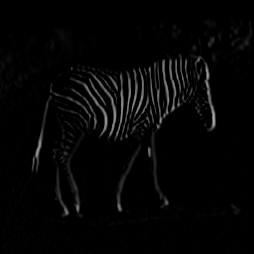

Y Derivative


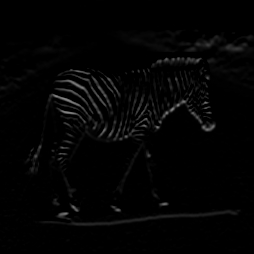

Gradient Magnitude


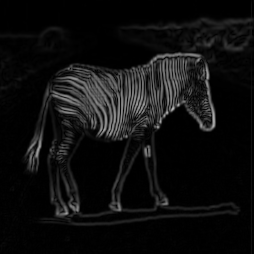

Edge Detection Image


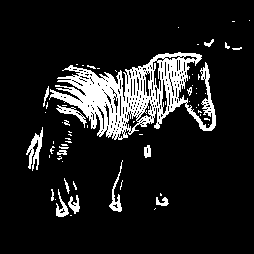

In [ ]:
im_in = preprocess_img('zebra.png')
thresh1 = edgeDetection(im_in)

In [ ]:
def template_matching(template, image):
  image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

  mean = np.mean(template)
  max = np.amax(template)
  min = np.amin(template)

  print(mean, min, max)

  normalized_template = template - mean
  cv2_imshow(normalized_template)

  image = cv.convertScaleAbs(image)
  normalized_template = cv.convertScaleAbs(normalized_template)

  template_height, template_width = normalized_template.shape[:2]
  image_height, image_width = image.shape[:2]

  correlation_image = cv.matchTemplate(image, template, cv.TM_CCOEFF_NORMED)
  min_val, max_val, min_loc, max_loc = cv.minMaxLoc(correlation_image)

  top_left = max_loc
  bottom_right = (top_left[0] + template_width, top_left[1] + template_height)

  image_with_circle = image.copy()
  cv.circle(image_with_circle, max_loc, 10, (0, 0, 255), 2)

  plt.subplot(1, 3, 1), plt.imshow(correlation_image, cmap='gray')
  plt.title('Correlation Image'), plt.xticks([]), plt.yticks([])

  plt.subplot(1, 3, 2), plt.imshow(image, cmap='gray')
  plt.title('Original Image'), plt.xticks([]), plt.yticks([])
  plt.imshow(image, cmap='gray'), plt.axis('off')
  plt.gca().add_patch(plt.Rectangle(top_left, template_width, template_height, edgecolor='b', facecolor='none'))

  plt.subplot(1, 3, 3), plt.imshow(image_with_circle, cmap='gray')
  plt.title('Detected Location'), plt.xticks([]), plt.yticks([])

  plt.show()

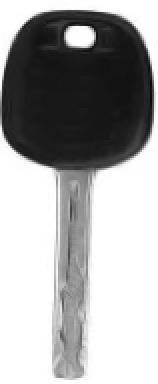

167.42616033755274 7 255


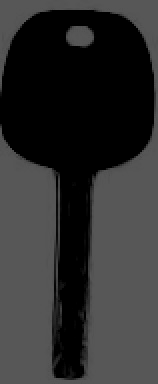

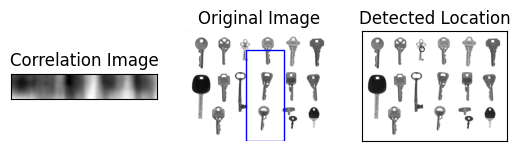

In [ ]:
image = cv.imread('multiplekeys.png')
template = cv.imread('Key2.jpeg')
cv2_imshow(template)
template_matching(template, image)

In [ ]:
def rgb_to_lch(rgb):
  lab = cv.cvtColor(rgb, cv.COLOR_RGB2LAB)
  lab = lab.astype(np.float32)

  L = lab[:,:,0] / 255.0
  a = lab[:,:,1] - 128.0
  b = lab[:,:,2] - 128.0

  C = np.sqrt(np.square(a) + np.square(b))
  H = np.arctan2(b, a)
  H[H < 0] += 2 * np.pi
  H = np.degrees(H)

  L = (L * 255).astype(float)
  C = (C * 255).astype(float)
  H = (H * 255 / 360).astype(float)

  return L, C, H

In [ ]:
def colorEdgeDetection(im_in):
  print('Original Image')
  cv2_imshow(im_in)
  b, g, r = cv.split(im_in)
  print('Blue')
  cv2_imshow(b)
  print('Green')
  cv2_imshow(g)
  print('Red')
  cv2_imshow(r)
  gray = cv.cvtColor(im_in, cv.COLOR_BGR2GRAY)
  print('Grayscale')
  cv2_imshow(gray)
  thresh1 = edgeDetection(b)
  thresh2 = edgeDetection(g)
  thresh3 = edgeDetection(r)
  thresh4 = edgeDetection(gray)
  merge = cv.merge([thresh3, thresh2, thresh1])
  print('Merge')
  cv2_imshow(merge)
  L, C, H = rgb_to_lch(im_in)
  print('L')
  cv2_imshow(L)
  print('C')
  cv2_imshow(C)
  print('H')
  cv2_imshow(H)
  thresh1 = edgeDetection(L)
  thresh2 = edgeDetection(C)
  thresh3 = edgeDetection(H)

Original Image


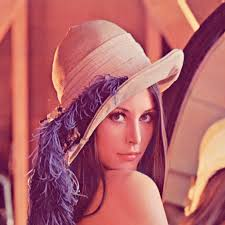

Blue


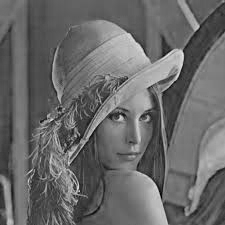

Green


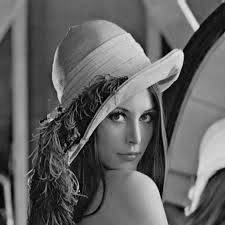

Red


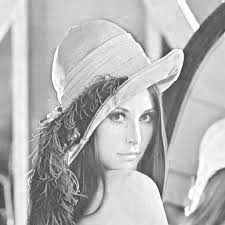

Grayscale


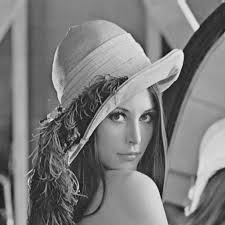

Edge Det - Input


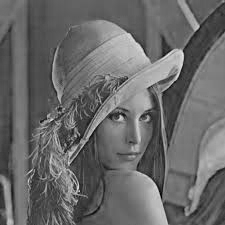

2D Gaussian Blur


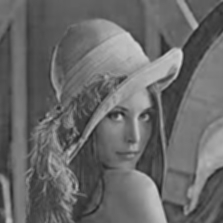

1D Gaussian Blur


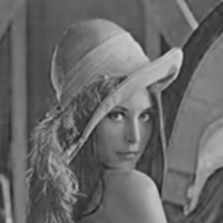

X Derivative


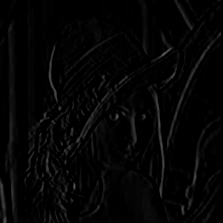

Y Derivative


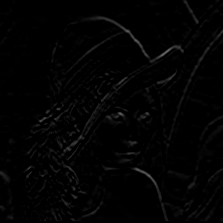

Gradient Magnitude


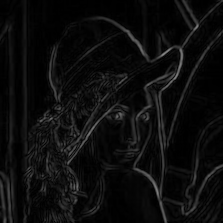

Edge Detection Image


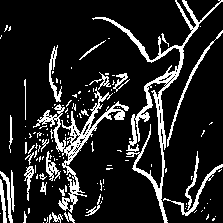

Edge Det - Input


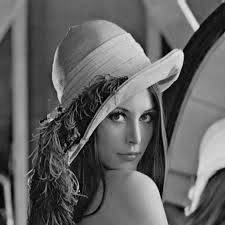

2D Gaussian Blur


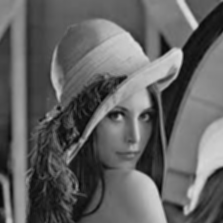

1D Gaussian Blur


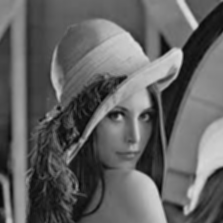

X Derivative


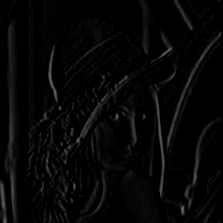

Y Derivative


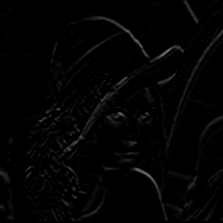

Gradient Magnitude


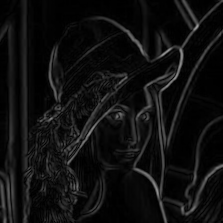

Edge Detection Image


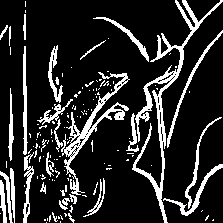

Edge Det - Input


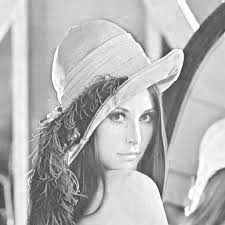

2D Gaussian Blur


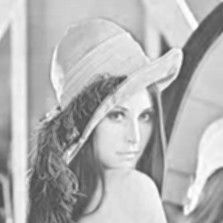

1D Gaussian Blur


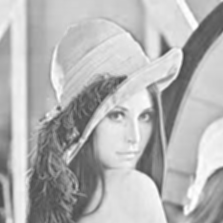

X Derivative


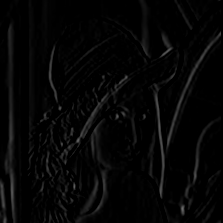

Y Derivative


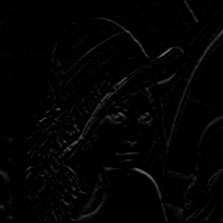

Gradient Magnitude


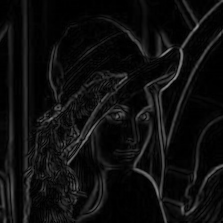

Edge Detection Image


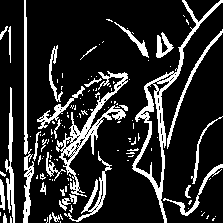

Edge Det - Input


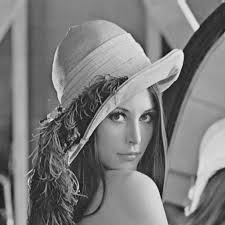

2D Gaussian Blur


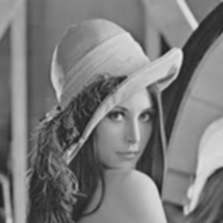

1D Gaussian Blur


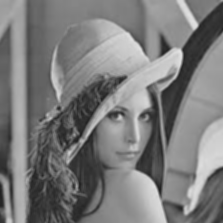

X Derivative


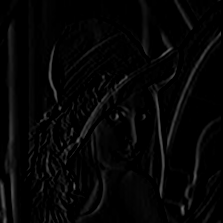

Y Derivative


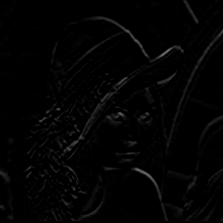

Gradient Magnitude


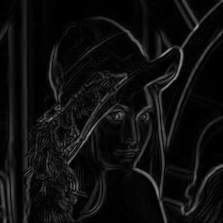

Edge Detection Image


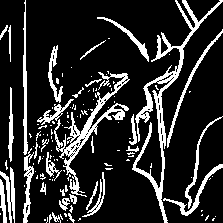

Merge


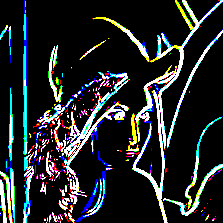

L


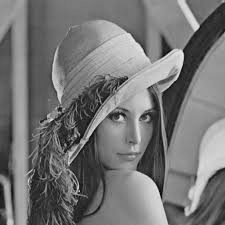

C


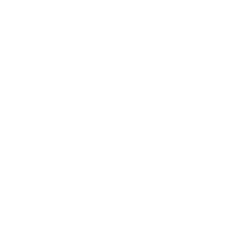

H


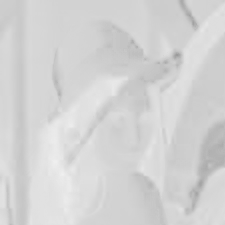

Edge Det - Input


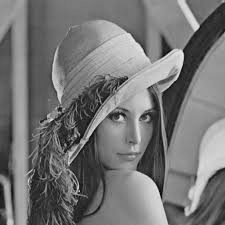

2D Gaussian Blur


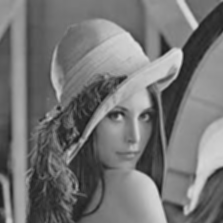

1D Gaussian Blur


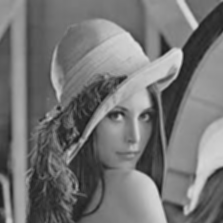

X Derivative


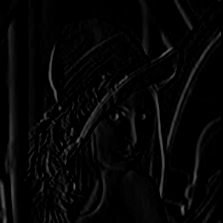

Y Derivative


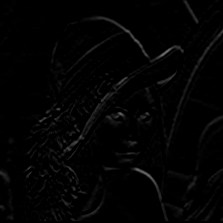

Gradient Magnitude


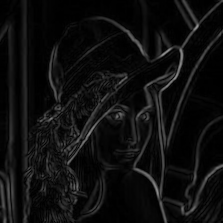

Edge Detection Image


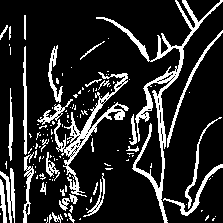

Edge Det - Input


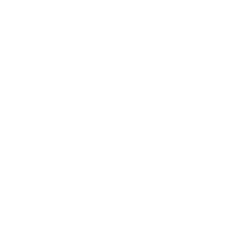

2D Gaussian Blur


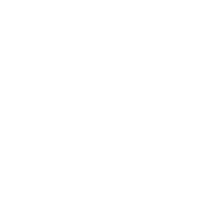

1D Gaussian Blur


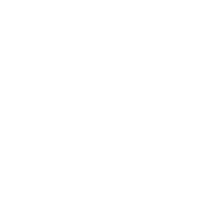

X Derivative


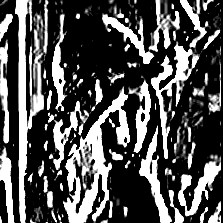

Y Derivative


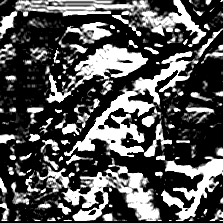

Gradient Magnitude


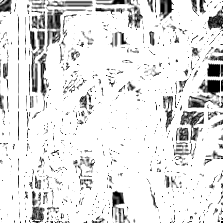

Edge Detection Image


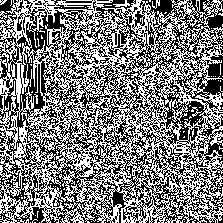

Edge Det - Input


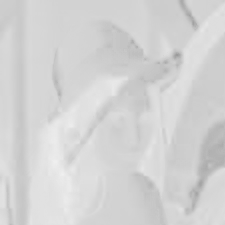

2D Gaussian Blur


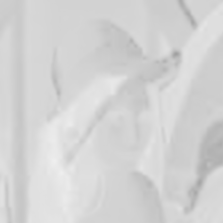

1D Gaussian Blur


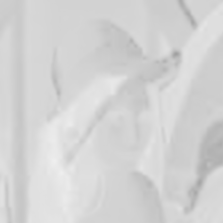

X Derivative


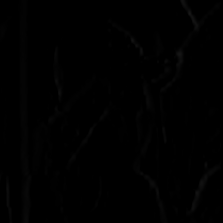

Y Derivative


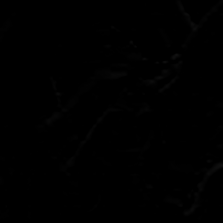

Gradient Magnitude


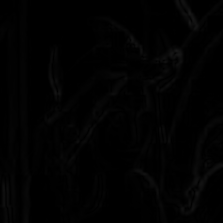

Edge Detection Image


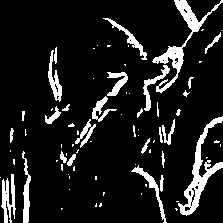

In [ ]:
im_in = cv.imread('lena.jpeg')
colorEdgeDetection(im_in)